In [268]:
%matplotlib inline
import os
import sys
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
import pdb
import h5py
import subprocess
import datetime
import pandas as pd

import platform
if platform.system() == 'Darwin':
    # On a Mac: usetex ok
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=True)
elif platform.node().startswith("D"):
    # On hyak: usetex not ok, must change backend to 'agg'
    mpl.rc('font',**{'family':'serif','serif':['Computer Modern']})
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)
    plt.switch_backend('agg')
else:
    # On astro machine or other linux: usetex not ok
    plt.switch_backend('agg')
    mpl.rc('font', family='Times New Roman')
    mpl.rcParams['font.size'] = 25.0
    mpl.rc('text', usetex=False)

In [2]:
import smart
import coronagraph as cg
import pandas as pd

/Users/Jake/anaconda2/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/Users/Jake/anaconda2/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/Users/Jake/anaconda2/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/Users/Jake/anaconda2/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/Users/Jake/anaconda2/lib/python2.7/site-packages/pandas/core/indexes/base.py:7: Ru

In [3]:
sys.path.insert(1, "../scripts")

import spectroscopy

In [4]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

Text(0,0.5,'Reflectivity')

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


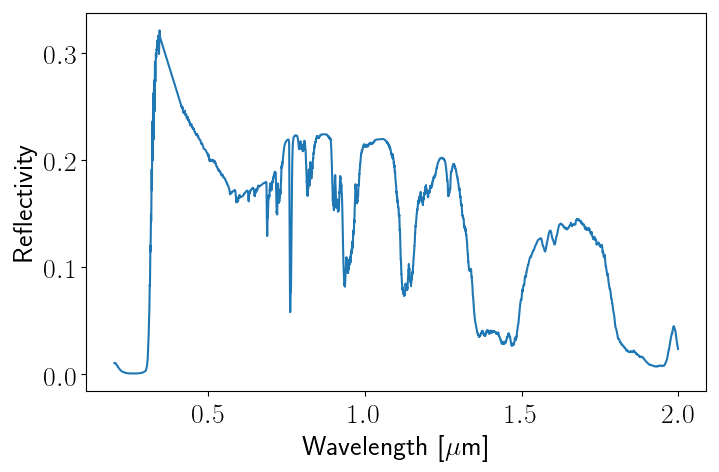

In [5]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

lammin = 0.2
lammax = 2.0
m = (lamhr > lammin) & (lamhr < lammax)

plt.plot(lamhr[m], Ahr[m])
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("Reflectivity")

In [6]:
# Create generic coronagraph noise object
cn = cg.CoronagraphNoise()

/Users/Jake/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


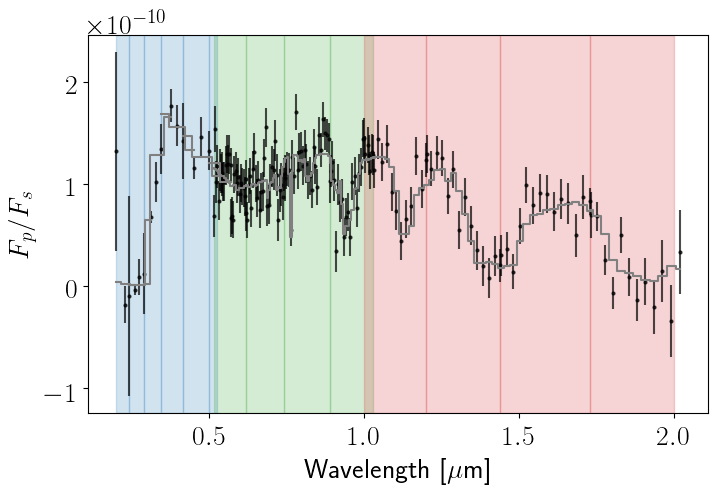

In [7]:
t_tot, tpbpc, spectrum, iwa = spectroscopy.complete_spectrum_time(cn, plot=True)

In [8]:
t_tot

14057.483377186905

In [9]:
biased_sample = spectroscopy.read_luvoir_stars()
biased_sample.keys()

[u'hip', u'dist', u'stype']

In [10]:
NBIAS = len(biased_sample["dist"])

In [11]:
wantSNR = 5.0

# Perform calculation for all stars in biased sample
biased_sample = spectroscopy.read_luvoir_stars()
Ndraw = len(biased_sample["dist"])

np.random.seed(seed=None)

# Allocate memory for exposure times
t_tots = np.zeros(Ndraw)
tpbpcs = []
pct_obs_iwas = []
lammax_obs_iwas = []
specs = []
    
# Randomly draw sample indices
#idraw = np.random.choice(np.arange(len(hip)), size=Ndraw, replace=False)

# Order systems by "detectability"
#idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now

# Loop over stars in this sample
for i in range(Ndraw):
    #print("HIP %i, %.2f pc, %s " %(hip[i], dist[i], stype[i]))

    # Set system parameters for this star
    cn = spectroscopy.prep_ith_star(cn, i)
    
    # Calculate the time to observe the complete spectrum
    t_tots[i], tpbpc, spectrum, iwa = spectroscopy.complete_spectrum_time(cn, plot=False) 
    
    tpbpcs.append(tpbpc)
    pct_obs_iwas.append(iwa[0])
    specs.append(spectrum)

/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:288: RuntimeWarning: divide by zero encountered in true_divide
  Csig = self.Cratio/SNRt
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:289: RuntimeWarning: divide by zero encountered in true_divide
  Asig = self.A/SNRt
../scripts/spectroscopy.py:328: RuntimeWarning: divide by zero encountered in double_scalars
  t_snr = (wantsnr**2 - intercept) / slope
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:285: RuntimeWarning: invalid value encountered in multiply
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)
/Users/Jake/Projects/coronagraph/coronagraph/count_rates.py:285: RuntimeWarning: invalid value encountered in true_divide
  SNRt  = self.cp * Dt / np.sqrt((self.cp + roll_factor*self.cb) * Dt)


In [12]:
# Calculate channel widths
deltas = []
for channel in spectroscopy.CHANNELS:
    l = spectroscopy.default_luvoir(channel=channel)
    deltas.append(l.lammax - l.lammin)
deltas = np.array(deltas)

channel_weights = (deltas / np.sum(deltas))

completeness = np.sum(np.array(pct_obs_iwas) * channel_weights, axis = 1)

Text(0,0.5,'Total Exposure Time [hrs]')

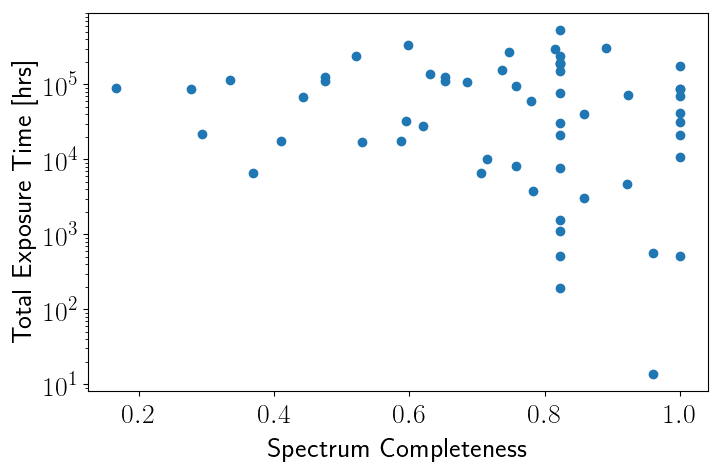

In [13]:
plt.plot(completeness, t_tots, "o")
plt.yscale("log")
plt.xlabel("Spectrum Completeness")
plt.ylabel("Total Exposure Time [hrs]")

In [14]:
# Max Number of channels to remove
N = 3

tpbpcs_N = [tpbpcs]
modcomps_N = np.zeros((N+1, NBIAS))
completeness_N = np.zeros((N+1, NBIAS))
t_tots_N = np.zeros((N+1, NBIAS))

modcomps_N[0,:]
completeness_N[0,:] = completeness
t_tots_N[0,:] = t_tots

for i in range(N):
    tmpt = []
    tmpc = []
    for j in range(NBIAS):
        new_tpbpc, modtime, modcomp, maxderiv = spectroscopy.remove_worst_bandpass(tpbpcs_N[-1][j], specs[j])
        tmpt.append(new_tpbpc)
        modcomps_N[i+1,j] = modcomp
        completeness_N[i+1,j] = completeness[j] - np.sum(modcomps_N[:,j])
        t_tots_N[i+1,j] = spectroscopy.apply_two_channels(spectroscopy.calc_t_chan(new_tpbpc))
    tpbpcs_N.append(tmpt)

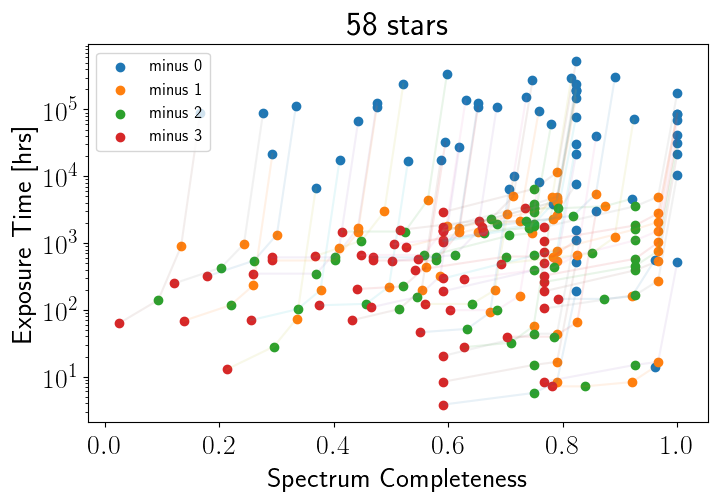

In [15]:
fig, ax = plt.subplots()

for i in range(N+1):
    s = ax.scatter(completeness_N[i,:], t_tots_N[i,:], marker = "o", label = "minus %i" %(i))

for i in range(NBIAS):
    ax.plot(completeness_N[:,i], t_tots_N[:,i], alpha = 0.1)
    
ax.set_yscale("log")
ax.set_title("%i stars" %NBIAS)
#plt.colorbar(s, label = clabel)
ax.set_xlabel("Spectrum Completeness")
ax.set_ylabel("Exposure Time [hrs]")
ax.legend(fontsize = 12)

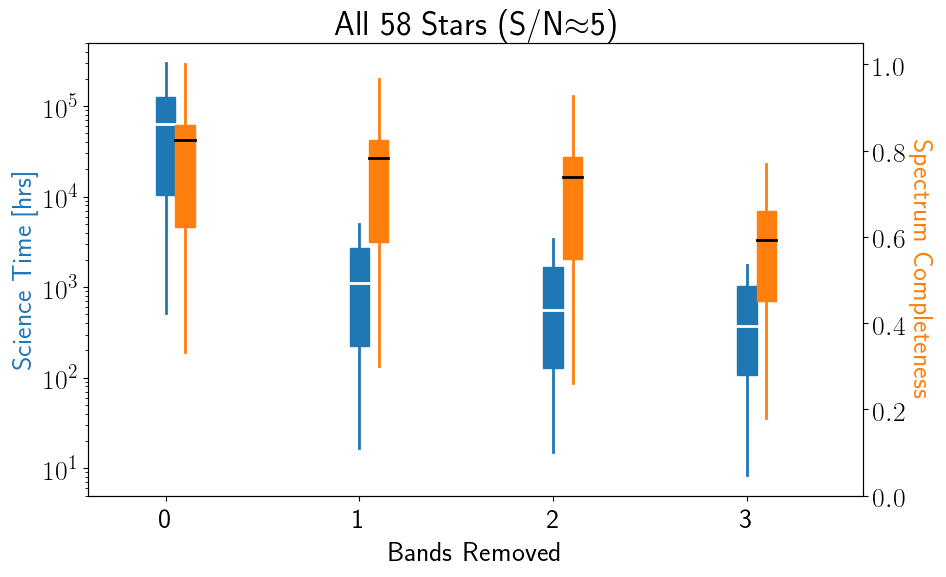

In [16]:
fig2, ax2 = plt.subplots(figsize = (10,6))
ax3 = ax2.twinx()
    
data = [t_tots_N[i,:] for i in range(N+1)]
color1 = "C0"
positions = np.arange(N+1)
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

data = [completeness_N[i,:] for i in range(N+1)]
color2 = "C1"
positions = np.arange(N+1) + 0.1
bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                 whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "k", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)
for patch in bp2['boxes']:
    patch.set_facecolor(color2)
    
ax2.set_ylabel("Science Time [hrs]", color = color1)
ax2.set_title(r"All %i Stars (S/N$\approx$%i)" %(NBIAS, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Bands Removed")
ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
ax3.set_ylim(0.0,1.05)

ax2.set_xticks(np.arange(N+1));
ax2.set_xticklabels(np.arange(N+1));

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:3238: RuntimeWarning: invalid value encountered in double_scalars
  in cbook.safezip(data, err)]
/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1792: RuntimeWarning: invalid value encountered in double_scalars
  notch_min = med - 1.57 * iqr / np.sqrt(N)


(0.1, 2.0)

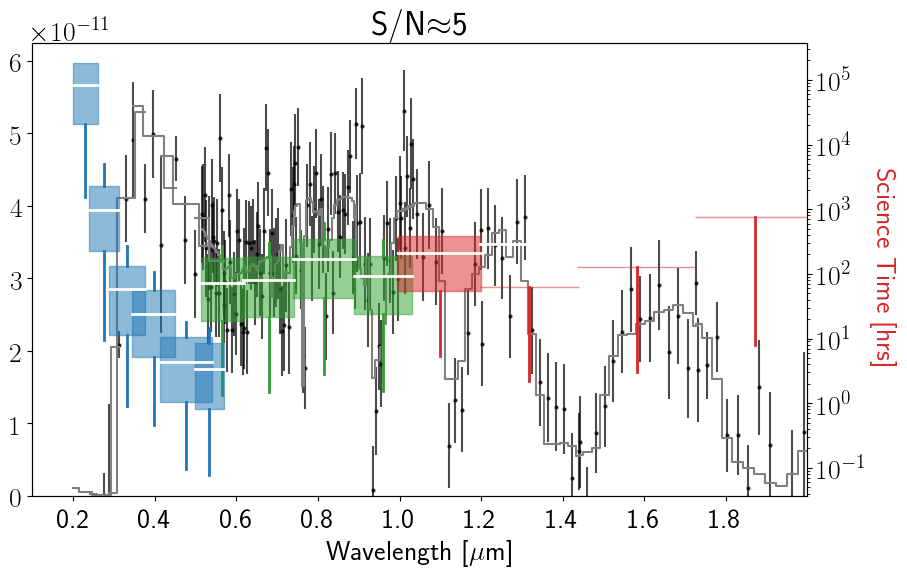

In [17]:
fig, ax = plt.subplots(figsize = (10,6))
cc = ["C0", "C2", "C3"]

ax2 = ax.twinx()

#ax.plot(lamhr, Ahr, c = "k", zorder = 100)
#ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
#ax.set_ylabel("Geometric Albedo")

tmp = [np.zeros((len(tpbpcs[0][i]), len(tpbpcs))) for i in range(len(tpbpcs[0]))]
for i in range(len(tpbpcs)):
    for j in range(len(tpbpcs[0])):
        tmp[j][:,i] = tpbpcs[i][j]

icount = 0
for j in range(len(tmp)):
    
    data = []
    positions = []
    widths = []
    for i in range(tmp[j].shape[0]):
        data.append(tmp[j][i,:])
        positions.append(np.mean(specs[0][0][icount]))
        widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0])
        
        ax.plot(specs[0][0][icount], specs[0][1][icount], ls = "steps-mid", color = "grey", zorder = 100)
        ax.errorbar(specs[0][0][icount], specs[0][2][icount], yerr=specs[0][3][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        
        icount += 1
        
    color1 = cc[j]
    positions = np.array(positions)
    widths = np.array(widths)
    bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                      boxprops = {"color" : color1, "alpha" : 0.5}, 
                      whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                      capprops = {"color" : color1, "linewidth" : 0.0}, 
                      medianprops = {"color" : "w", "linewidth" : 2.0}, 
                      patch_artist=True, positions = positions, whis = [5, 95]); 

    for patch in bp1['boxes']:
        patch.set_facecolor(color1)
    
ax2.set_ylabel("Science Time [hrs]", color = color1, rotation = 270, labelpad = 22)
ax2.set_title(r"S/N$\approx$%i" %wantSNR)
ax2.set_yscale("log")

ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylim(bottom = 0.0)

ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])
ax2.set_xlim(0.1, 2.0)

In [18]:
Xdraw = 500    # Number for unbiased random samples
Ndraw = 5      # Number of stars to randomly draw from biased sample
Nrem = 1

np.random.seed(seed=None)

# Get index with matching stellar type in stellar properties table
imatches = np.array([spectroscopy.match_stellar_type(biased_sample["stype"][j], verbose = False) for j in range(NBIAS)])

# Allocate memory for exposure times
ctime_tot = np.zeros((Ndraw, Xdraw))
ccomp_tot = np.zeros((Ndraw, Xdraw))

# Loop over number of random draws (for bootstrapping distributions)
for ix in range(Xdraw):
    
    # Randomly draw sample indices
    idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
    
    # Order systems by "detectability" (sorting must happen at a later step)
    #idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now
    
    # Get the total exposure time and completeness for the selected stars
    ctime_tmp = t_tots_N[Nrem, idraw]
    ccomp_tmp = completeness_N[Nrem, idraw]
    
    # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
    isort = np.argsort(ctime_tmp)
    
    # Set exposure time for this star
    ctime_tot[:, ix] = ctime_tmp[isort]

    # Set completeness for this star
    ccomp_tot[:, ix] = ccomp_tmp[isort]

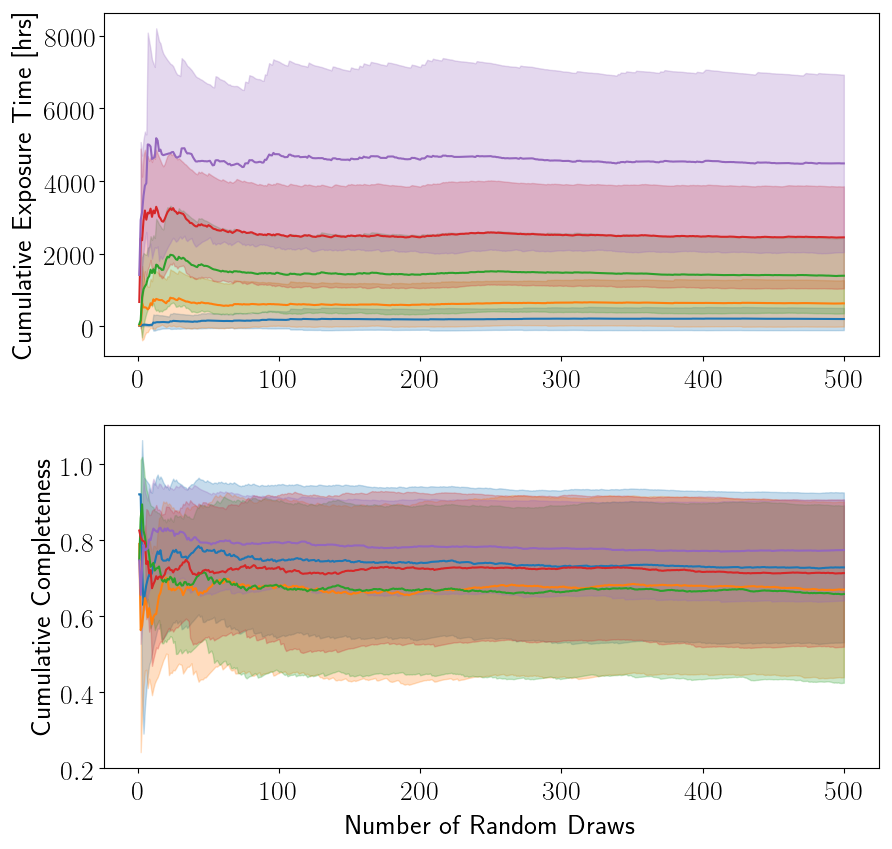

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (10,10))

# Loop over stars in sample
for i in range(Ndraw):
    
    # Calculate the cumulative mean time (to estimate convergence)
    cummean_time = pd.Series(ctime_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_time = pd.Series(ctime_tot[i,:]).expanding(1).std().values
    
    # Calculate the cumulative mean completeness (to estimate convergence)
    cummean_comp = pd.Series(ccomp_tot[i,:]).expanding(1).mean().values
    # Calculate the cumulative std deviation 
    cumstd_comp = pd.Series(ccomp_tot[i,:]).expanding(1).std().values
    
    # Plot time
    ax[0].plot((np.arange(Xdraw)+1), cummean_time, c = "C%i" %(i%9))
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[0].fill_between(np.arange(Xdraw)+1, cummean_time - cumstd_time, cummean_time + cumstd_time, alpha = 0.25, color = "C%i" %(i%9))
    ax[0].set_ylabel("Cumulative Exposure Time [hrs]")
    #ax[0].set_title("Full Spectrum")
    
     # Plot completeness
    ax[1].plot((np.arange(Xdraw)+1), cummean_comp, c = "C%i" %(i%9))
    #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
    ax[1].fill_between(np.arange(Xdraw)+1, cummean_comp - cumstd_comp, cummean_comp + cumstd_comp, alpha = 0.25, color = "C%i" %(i%9))
    ax[1].set_xlabel("Number of Random Draws")
    ax[1].set_ylabel("Cumulative Completeness")

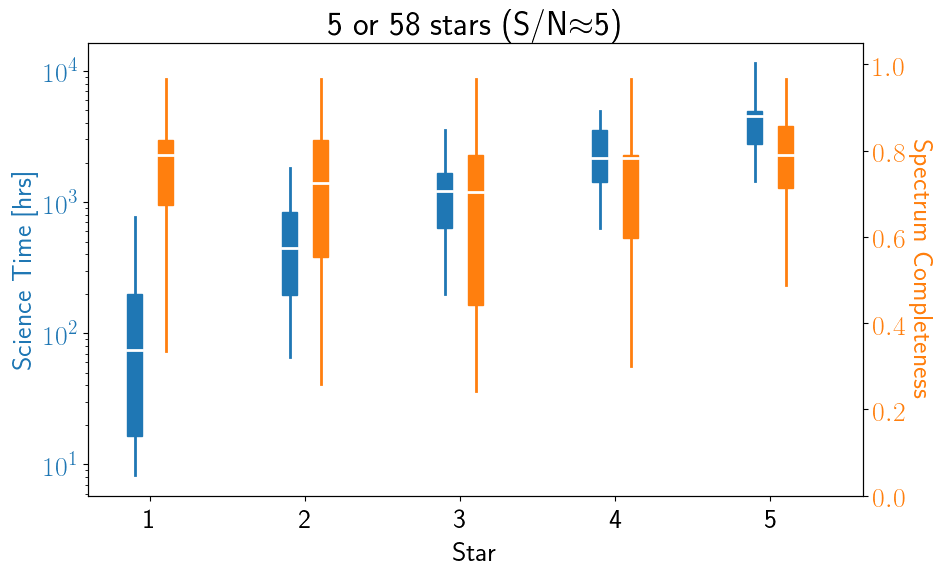

In [20]:
fig2, ax2 = plt.subplots(figsize = (10,6))
ax3 = ax2.twinx()

# Loop over stars in sample
for i in range(Ndraw):

    # Plot time intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ctime_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax2.errorbar(i+1, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "o", color = "C0")
    
    # Plot completeness intervals
    #q_l, q_50, q_h, q_m, q_p = nsig_intervals(ccomp_tot[i,:], intvls=[0.16, 0.5, 0.84])
    #ax3.errorbar(i+1.05, q_50, yerr = np.array([q_m, q_p]).reshape((2,1)), fmt = "x", color = "C1")
    #ax2[1].set_yscale("log")
    pass
    
data = [ctime_tot[i,:] for i in range(Ndraw)]
color1 = "C0"
positions = np.arange(Ndraw) + 0.9
bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                 whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

data = [ccomp_tot[i,:] for i in range(Ndraw)]
color2 = "C1"
positions = np.arange(Ndraw) + 1.1
bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                 whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                 patch_artist=True, positions = positions, whis = [5, 95]); 

for patch in bp1['boxes']:
    patch.set_facecolor(color1)
for patch in bp2['boxes']:
    patch.set_facecolor(color2)
    
_ = [i.set_color(color1) for i in ax2.get_yticklabels()];
_ = [i.set_color(color2) for i in ax3.get_yticklabels()];
    
ax2.set_ylabel("Science Time [hrs]", color = color1)
ax2.set_title(r"%i or %i stars (S/N$\approx$%i)" %(Ndraw, NBIAS, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Star")
ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
ax3.set_ylim(0.0,1.05)

ax2.set_xticks(np.arange(Ndraw)+1);
ax2.set_xticklabels(np.arange(Ndraw)+1);

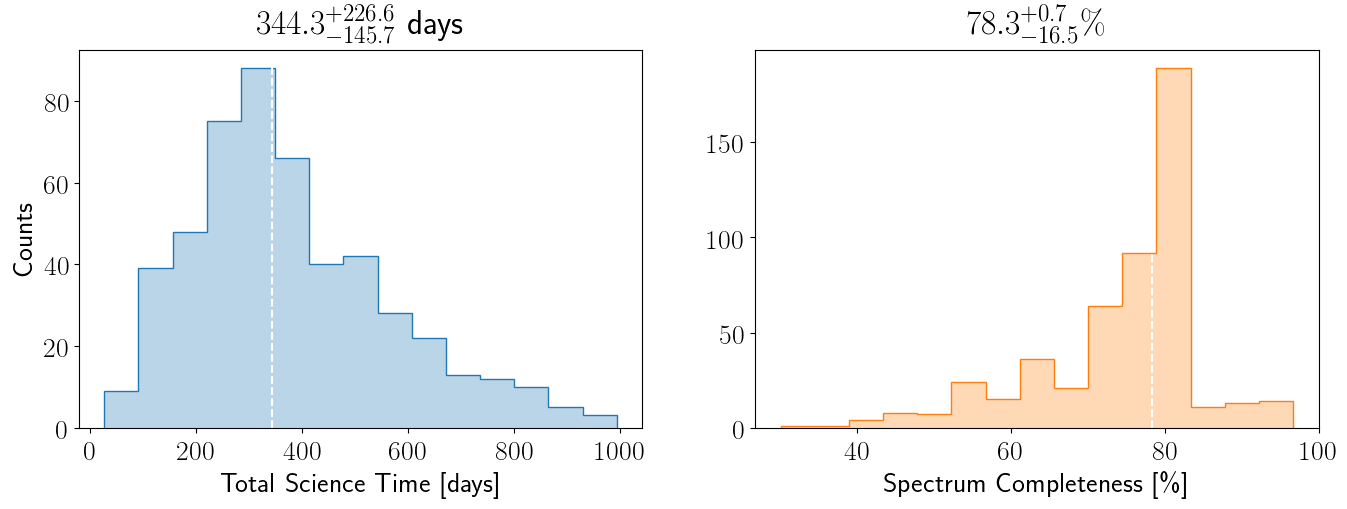

In [100]:
fig4, ax4 = plt.subplots(1, 2, figsize = (16,5))

ctime_sum = np.sum(ctime_tot, axis = 0) / 24.
ctime_med = np.median(ctime_sum)
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)

ax4[0].set_xlabel("Total Science Time [days]")
ax4[0].set_ylabel("Counts")
ax4[0].set_title(result)
ax4[0].hist(ctime_sum, bins = 15, alpha = .3, color = "C0");
ax4[0].hist(ctime_sum, bins = 15, alpha = 1.0, histtype="step", color = "C0");
ax4[0].axvline(ctime_med, color = "w", ls = "dashed")

ccomp_meds = np.median(ccomp_tot, axis = 0) * 100.
ccomp_med = np.median(ccomp_meds)
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ccomp_meds)
result = "$%.1f^{+%.1f}_{-%.1f} \%%$ " %(q_50, q_p, q_m)

ax4[1].set_xlabel("Spectrum Completeness [\%]")
ax4[1].set_title(result)
ax4[1].hist(ccomp_meds, bins = 15, alpha = .3, color = "C1");
ax4[1].hist(ccomp_meds, bins = 15, alpha = 1.0, histtype="step", color = "C1");
ax4[1].axvline(ccomp_med, color = "w", ls = "dashed")

In [103]:
def sample_complete_spectra(t_tots_N, completeness_N, Ndraw = 5, Xdraw = 500, Nrem = 0, 
                            plot_converge = False, plot_stats = True, plot_totals = True):
    """
    """
    
    #Xdraw = 500    # Number for unbiased random samples
    #Ndraw = 5      # Number of stars to randomly draw from biased sample
    #Nrem = 1
    
    """
    Randomly sample ``Ndraw`` stars ``Xdraw`` number of times
    """

    # Get index with matching stellar type in stellar properties table
    imatches = np.array([spectroscopy.match_stellar_type(biased_sample["stype"][j], verbose = False) for j in range(NBIAS)])

    # Allocate memory for exposure times
    ctime_tot = np.zeros((Ndraw, Xdraw))
    ccomp_tot = np.zeros((Ndraw, Xdraw))

    # Loop over number of random draws (for bootstrapping distributions)
    for ix in range(Xdraw):

        # Randomly draw sample indices
        idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)

        # Order systems by "detectability" (sorting must happen at a later step)
        #idraw = idraw[np.argsort(dist[idraw])]   # Simply distance for now

        # Get the total exposure time and completeness for the selected stars
        ctime_tmp = t_tots_N[Nrem, idraw]
        ccomp_tmp = completeness_N[Nrem, idraw]

        # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
        isort = np.argsort(ctime_tmp)

        # Set exposure time for this star
        ctime_tot[:, ix] = ctime_tmp[isort]

        # Set completeness for this star
        ccomp_tot[:, ix] = ccomp_tmp[isort]
        
    """
    Plot cumulative stats to test for stability
    """
    
    if plot_converge:
    
        fig, ax = plt.subplots(2, 1, figsize = (10,10))

        # Loop over stars in sample
        for i in range(Ndraw):

            # Calculate the cumulative mean time (to estimate convergence)
            cummean_time = pd.Series(ctime_tot[i,:]).expanding(1).mean().values
            # Calculate the cumulative std deviation 
            cumstd_time = pd.Series(ctime_tot[i,:]).expanding(1).std().values

            # Calculate the cumulative mean completeness (to estimate convergence)
            cummean_comp = pd.Series(ccomp_tot[i,:]).expanding(1).mean().values
            # Calculate the cumulative std deviation 
            cumstd_comp = pd.Series(ccomp_tot[i,:]).expanding(1).std().values

            # Plot time
            ax[0].plot((np.arange(Xdraw)+1), cummean_time, c = "C%i" %(i%9))
            #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
            ax[0].fill_between(np.arange(Xdraw)+1, cummean_time - cumstd_time, cummean_time + cumstd_time, alpha = 0.25, color = "C%i" %(i%9))
            ax[0].set_ylabel("Cumulative Exposure Time [hrs]")
            #ax[0].set_title("Full Spectrum")

             # Plot completeness
            ax[1].plot((np.arange(Xdraw)+1), cummean_comp, c = "C%i" %(i%9))
            #ax.errorbar(np.arange(Xdraw)+1, cummean, yerr=cumstd)
            ax[1].fill_between(np.arange(Xdraw)+1, cummean_comp - cumstd_comp, cummean_comp + cumstd_comp, alpha = 0.25, color = "C%i" %(i%9))
            ax[1].set_xlabel("Number of Random Draws")
            ax[1].set_ylabel("Cumulative Completeness")
            
    
    """
    Plot statistics
    """
    if plot_stats:
    
        fig2, ax2 = plt.subplots(figsize = (10,6))
        ax3 = ax2.twinx()

        data = [ctime_tot[i,:] for i in range(Ndraw)]
        color1 = "C0"
        positions = np.arange(Ndraw) + 0.9
        bp1 = ax2.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" :color1}, 
                         whiskerprops = {"color" : color1, "linewidth" : 2.0}, capprops = {"color" : color1, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                         patch_artist=True, positions = positions, whis = [5, 95]); 

        data = [ccomp_tot[i,:] for i in range(Ndraw)]
        color2 = "C1"
        positions = np.arange(Ndraw) + 1.1
        bp2 = ax3.boxplot(data, sym = '', widths = 0.1, showfliers = False, boxprops = {"color" : color2}, 
                         whiskerprops = {"color" : color2, "linewidth" : 2.0}, capprops = {"color" : color2, "linewidth" : 0.0}, medianprops = {"color" : "w", "linewidth" : 2.0}, 
                         patch_artist=True, positions = positions, whis = [5, 95]); 

        for patch in bp1['boxes']:
            patch.set_facecolor(color1)
        for patch in bp2['boxes']:
            patch.set_facecolor(color2)

        _ = [i.set_color(color1) for i in ax2.get_yticklabels()];
        _ = [i.set_color(color2) for i in ax3.get_yticklabels()];

        ax2.set_ylabel("Science Time [hrs]", color = color1)
        ax2.set_title(r"%i or %i stars (S/N$\approx$%i)" %(Ndraw, NBIAS, wantSNR))
        ax2.set_yscale("log")

        ax2.set_xlabel("Star")
        ax3.set_ylabel("Spectrum Completeness", rotation = 270, labelpad = 22, color = color2)
        ax3.set_ylim(0.0,1.05)
        
        ax2.set_xticks(np.arange(Ndraw)+1);
        ax2.set_xticklabels(np.arange(Ndraw)+1);
        
    if plot_totals:
        
        fig4, ax4 = plt.subplots(1, 2, figsize = (16,5))

        # Plot exposure time hist
        ctime_sum = np.sum(ctime_tot, axis = 0) / 24.
        ctime_med = np.median(ctime_sum)
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ctime_sum)
        result = "$%.1f^{+%.1f}_{-%.1f}$ days" %(q_50, q_p, q_m)
        ax4[0].set_xlabel("Total Science Time [days]")
        ax4[0].set_ylabel("Counts")
        ax4[0].set_title(result)
        ax4[0].hist(ctime_sum, bins = 15, alpha = .3, color = "C0");
        ax4[0].hist(ctime_sum, bins = 15, alpha = 1.0, histtype="step", color = "C0");
        ax4[0].axvline(ctime_med, color = "w", ls = "dashed")

        # Plot completeness hist
        ccomp_meds = np.median(ccomp_tot, axis = 0) * 100.
        ccomp_med = np.median(ccomp_meds)
        q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(ccomp_meds)
        result = "$%.1f^{+%.1f}_{-%.1f} \%%$ " %(q_50, q_p, q_m)
        ax4[1].set_xlabel("Spectrum Completeness [\%]")
        ax4[1].set_title(result)
        ax4[1].hist(ccomp_meds, bins = 15, alpha = .3, color = "C1");
        ax4[1].hist(ccomp_meds, bins = 15, alpha = 1.0, histtype="step", color = "C1");
        ax4[1].axvline(ccomp_med, color = "w", ls = "dashed")
    
    return 

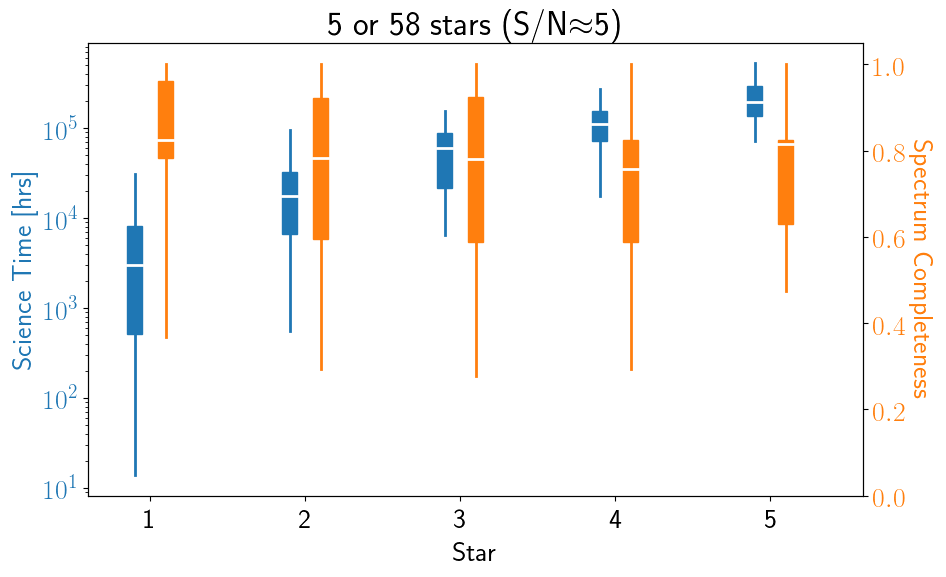

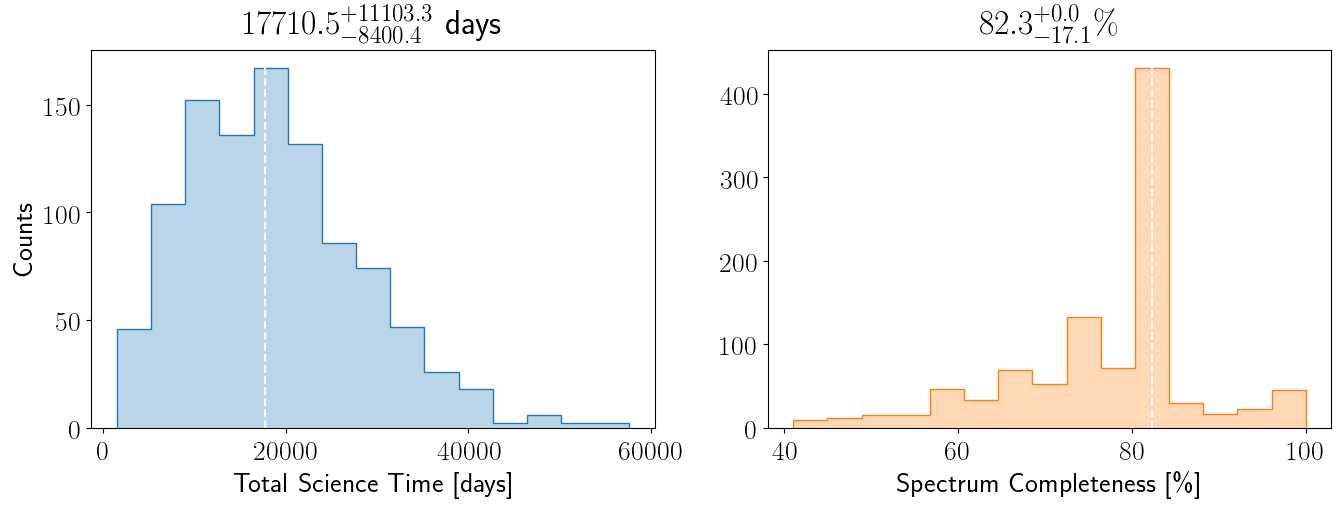

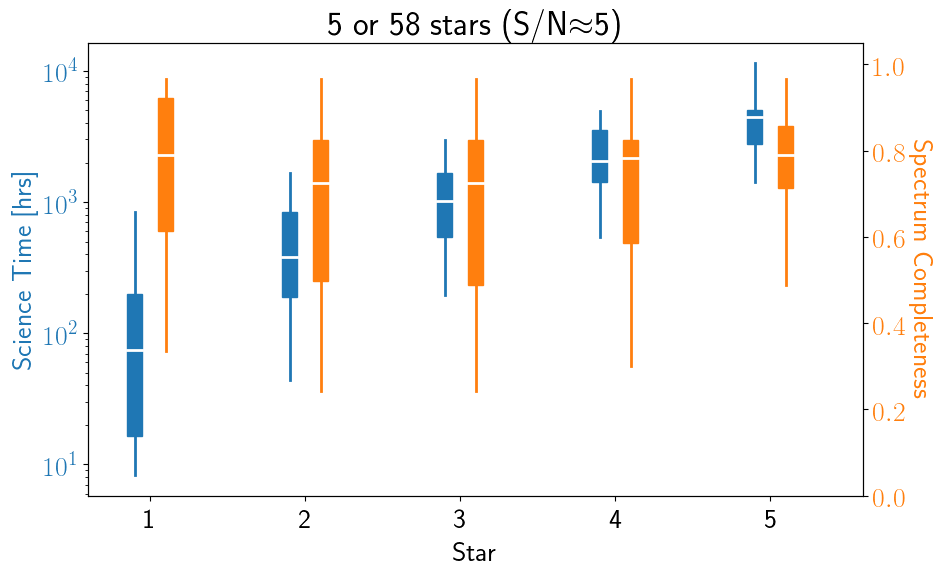

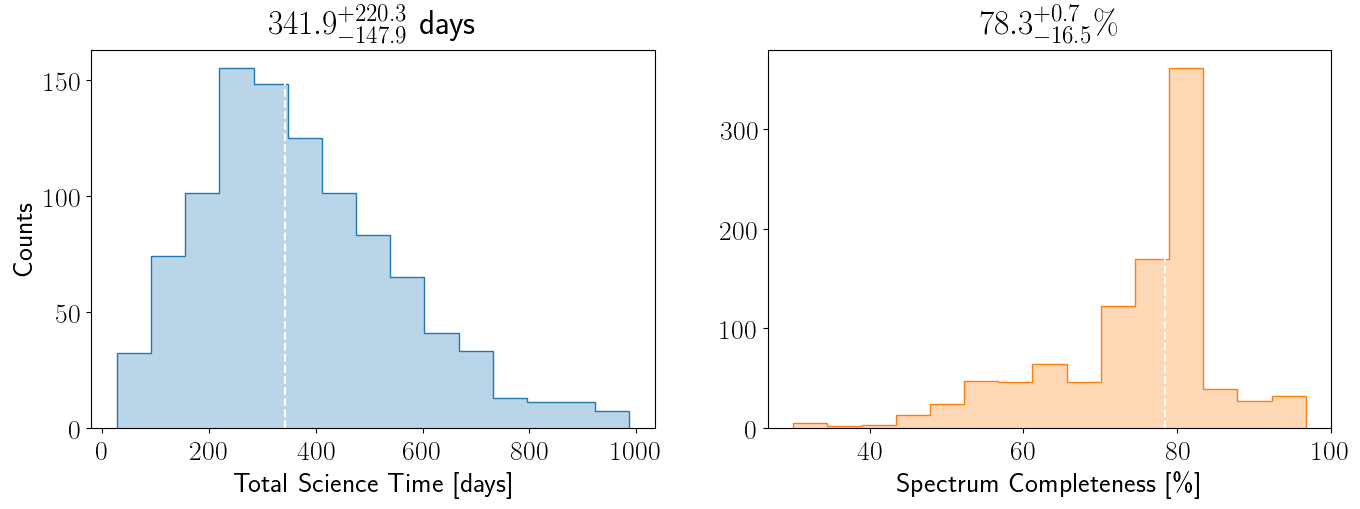

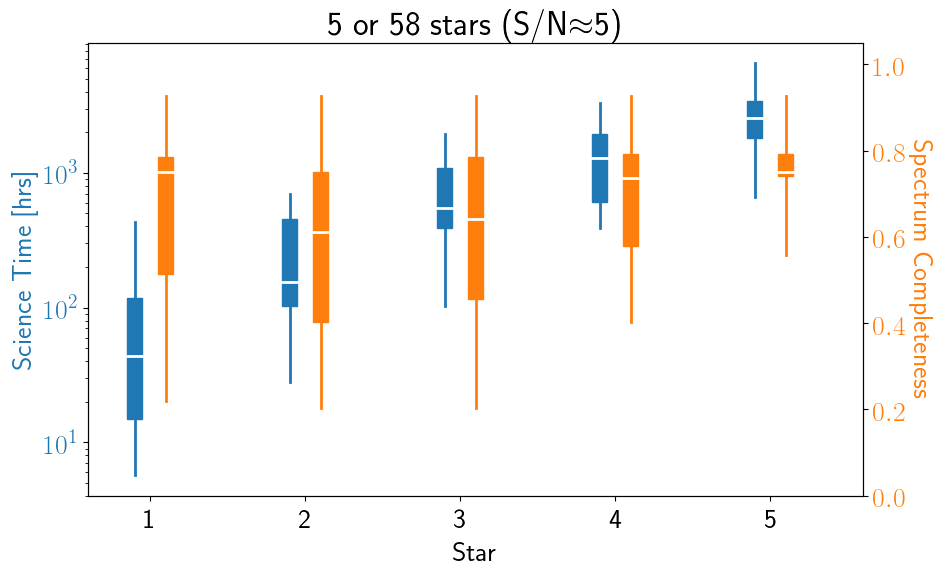

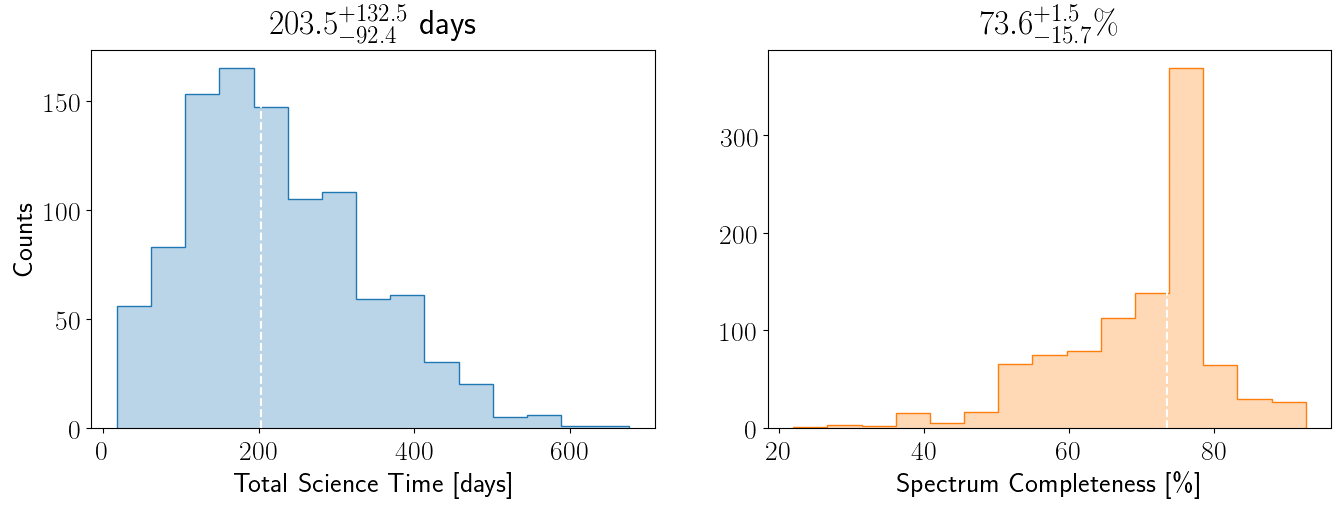

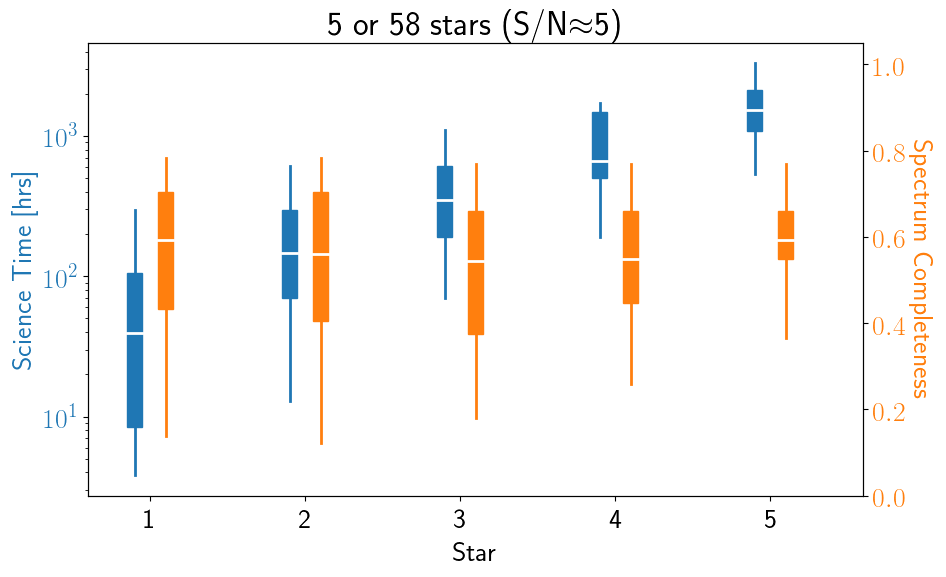

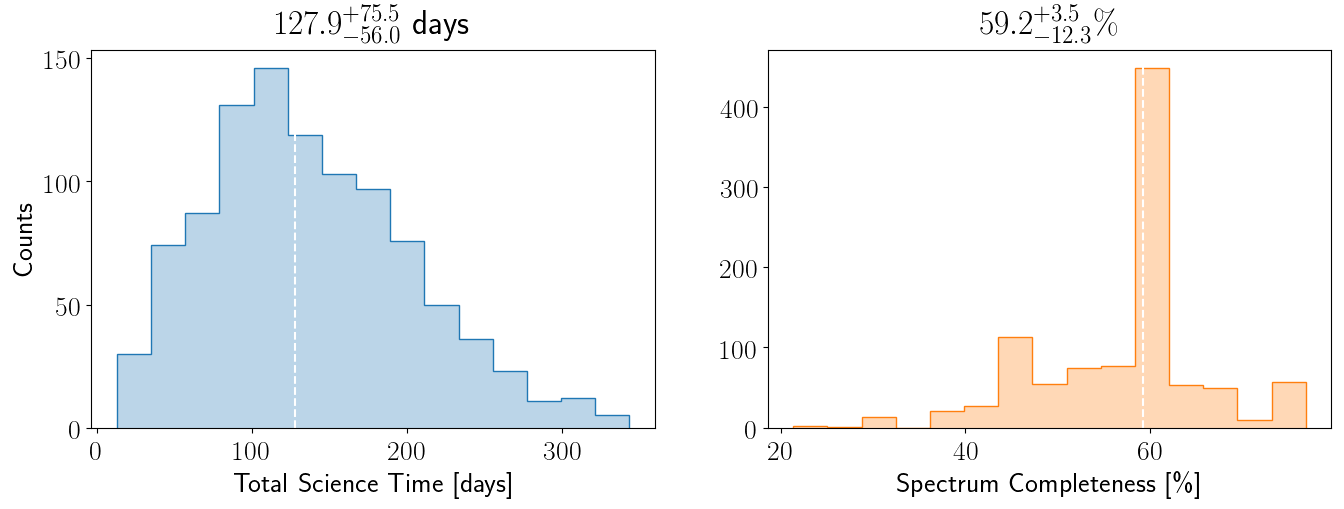

In [105]:
np.random.seed(seed=None)
Xdraw = 1000
Ndraw = 5     # of 58

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 0, 
                        plot_converge = False, plot_stats = True)

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 1, 
                        plot_converge = False, plot_stats = True)

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 2, 
                        plot_converge = False, plot_stats = True)

sample_complete_spectra(t_tots_N, completeness_N, Ndraw = Ndraw, Xdraw = Xdraw, Nrem = 3, 
                        plot_converge = False, plot_stats = True)

# Calculate Randomly Sampled Exposure Times for Each Bandpass

In [106]:
tpbpcs_draws = []

for ix in range(Xdraw):
    
    tpbpcs_draws.append([])
    
    # Randomly draw sample indices
    idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
    
    for iy in range(Ndraw):
        
        tpbpcs_draws[ix].append(tpbpcs[idraw[iy]])

In [207]:
tpbpcs_draws_stars = []
tpbpcs_draws_tots = []
comp_draws_stars = []

for ichan in range(len(spectroscopy.CHANNELS)):
    
    tpbpcs_draws_stars.append([])
    tpbpcs_draws_tots.append([])
    comp_draws_stars.append([])
        
    for iband in range(len(tpbpcs[0][ichan])):
                
        samples = np.zeros((Ndraw, Xdraw))
        for ix in range(Xdraw):
            
            # Randomly draw sample indices
            idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)
            
            # Get exptimes for each star drawn
            tmp_draws = np.array([tpbpcs[idrew][ichan][iband] for idrew in idraw])
            
            # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
            isort = np.argsort(tmp_draws)
            
            # Apply sorting
            samples[:,ix] = tmp_draws[isort]
        
        # Make infs --> nans
        infmask = ~np.isfinite(samples)
        samples[infmask] = np.nan
        
        # Count completeness factor
        comp_samples = np.copy(samples)
        comp_samples[infmask] = 0.0
        comp_samples[~infmask] = 1.0
        comp_count = np.sum(comp_samples, axis = 1) / Xdraw
        
        # Calculate medians for each star
        mps = np.nanmedian(samples, axis=1)
        print("%s channel, band %i:" %(spectroscopy.CHANNELS[ichan], iband+1))
        print(mps)
        print(comp_count)
        
        # Calculate the median total exptime
        x = np.nansum(samples, axis=0)
        
        tpbpcs_draws_stars[ichan].append(samples)
        tpbpcs_draws_tots[ichan].append(x)
        comp_draws_stars[ichan].append(comp_count)

UV channel, band 1:
[  6393.39270197  27107.91584636  84244.67342702 135864.08640998
 190915.62175165]
[1.    1.    0.997 0.945 0.616]
UV channel, band 2:
[  44.49641007  409.45387832  908.13733277 1578.86056535 4142.44635389]
[1.    1.    1.    1.    0.924]
UV channel, band 3:
[  3.44371439  28.03885319  58.7088644   93.3623959  240.58227168]
[1. 1. 1. 1. 1.]
UV channel, band 4:
[ 1.44055781 12.05400246 24.03990318 36.50926594 94.66951506]
[1. 1. 1. 1. 1.]
UV channel, band 5:
[ 0.29146597  2.07825975  4.19725932  6.28924268 15.25755299]
[1. 1. 1. 1. 1.]
UV channel, band 6:
[ 0.22451728  1.47648602  3.44058199  4.90720474 11.75849372]
[1. 1. 1. 1. 1.]
vis channel, band 1:
[  5.90109518  30.16268546  76.16290374 109.69279672 242.55579018]
[1. 1. 1. 1. 1.]
vis channel, band 2:
[  7.00182072  31.905586    79.75197713 124.00548275 263.8163011 ]
[1. 1. 1. 1. 1.]
vis channel, band 3:
[ 12.06186477  56.08095831 178.60944295 277.18541791 470.3039507 ]
[1.    1.    1.    1.    0.923]
vis channe

## Plot the total exposure time for all eta_interesting stars in sample

(0.1, 2.0)

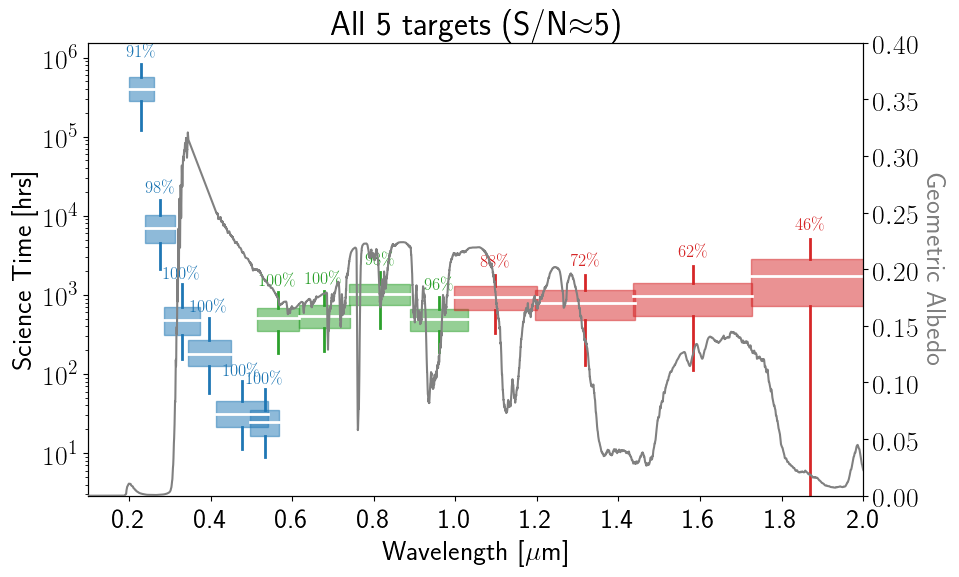

In [235]:
fig, ax2 = plt.subplots(figsize = (10,6))
cc = ["C0", "C2", "C3"]

ax = ax2.twinx()

ax.plot(lamhr, Ahr, c = "grey", zorder = 100)
ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
ax.set_ylabel("Geometric Albedo", rotation = 270, labelpad = 22, color = "grey")

# Transform quantities for boxplot
tmp = [np.zeros((len(tpbpcs_draws_tots[i]), Xdraw)) for i in range(len(spectroscopy.CHANNELS))]
for i in range(Xdraw):
    for j in range(len(tpbpcs_draws_tots)):
        for k in range(len(tpbpcs_draws_tots[j])):
            tmp[j][k,i] = tpbpcs_draws_tots[j][k][i]

icount = 0
for j in range(len(tmp)):
    
    data = []
    positions = []
    widths = []
    for i in range(tmp[j].shape[0]):
        data.append(tmp[j][i,:])
        positions.append(np.mean(specs[0][0][icount]))
        widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0])
        
        comp_str = "$%i \%%$" %(100.*np.mean(comp_draws_stars[j][i]))
        ax2.text(positions[i], np.median(tmp[j][i,:]) + 5.*np.std(tmp[j][i,:]), comp_str, 
                 ha = "center", va = "top", fontsize = 12, color = cc[j])
        
        #ax.plot(specs[0][0][icount], specs[0][1][icount], ls = "steps-mid", color = "grey", zorder = 100)
        #ax.errorbar(specs[0][0][icount], specs[0][2][icount], yerr=specs[0][3][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")
        
        icount += 1
        
    color1 = cc[j]
    positions = np.array(positions)
    widths = np.array(widths)
    bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                      boxprops = {"color" : color1, "alpha" : 0.5}, 
                      whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                      capprops = {"color" : color1, "linewidth" : 0.0}, 
                      medianprops = {"color" : "w", "linewidth" : 2.0}, 
                      patch_artist=True, positions = positions, whis = [5, 95]); 

    for patch in bp1['boxes']:
        patch.set_facecolor(color1)
    
ax2.set_ylabel("Science Time [hrs]")
ax2.set_title(r"All %i targets (S/N$\approx$%i)" %(Ndraw, wantSNR))
ax2.set_yscale("log")

ax2.set_xlabel("Wavelength [$\mu$m]")
ax2.set_ylim(bottom = 0.0)

ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
ax2.set_xlim(0.1, 2.0)

## Plot the exposure time and completeness in each band for randomly sampled stars

/Users/Jake/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


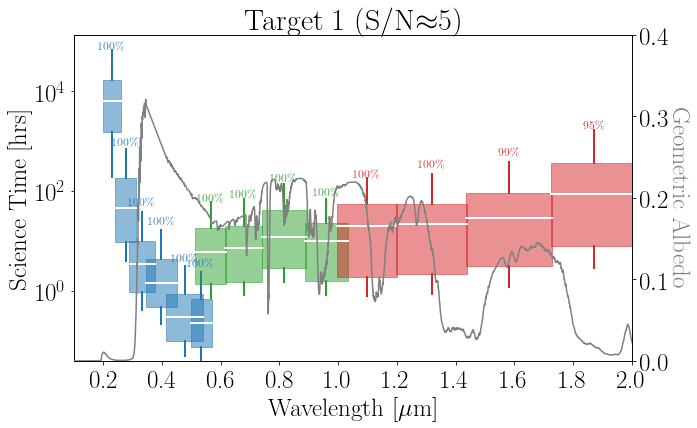

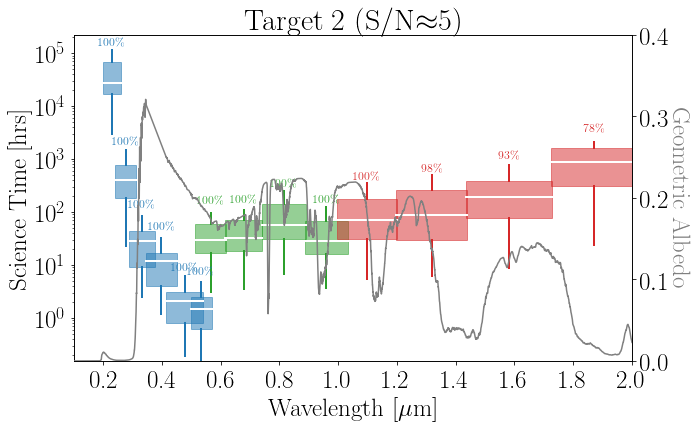

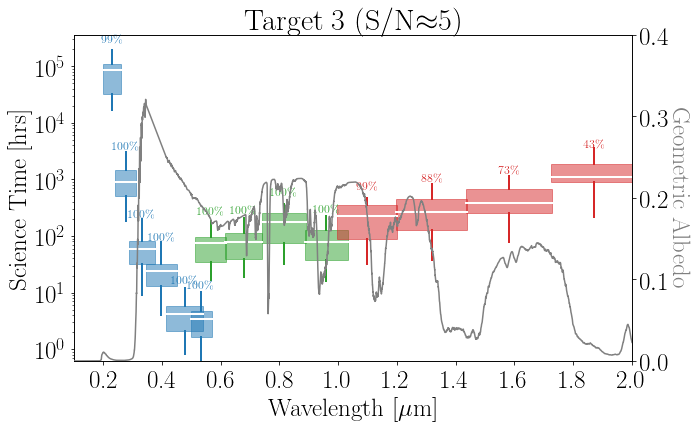

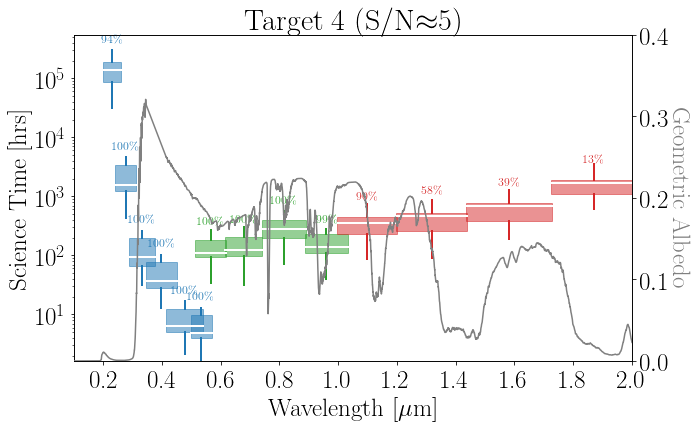

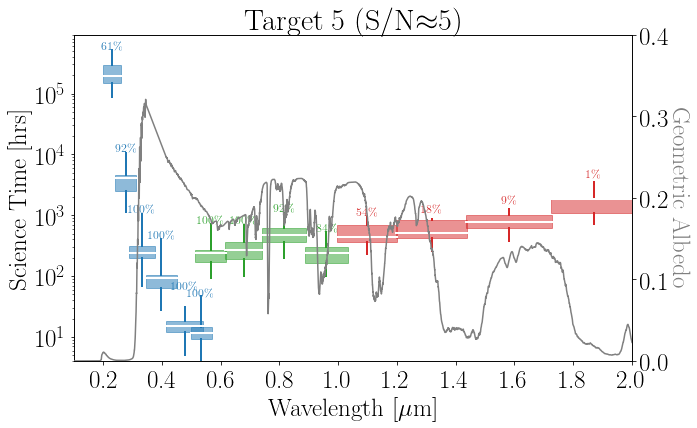

In [299]:
for itarget in range(Ndraw):
    
    fig, ax2 = plt.subplots(figsize = (10,6))
    cc = ["C0", "C2", "C3"]

    ax = ax2.twinx()

    ax.plot(lamhr, Ahr, c = "grey", zorder = 100)
    ax.set_ylim(0.0, 0.1*np.ceil(10*np.max(Ahr[lamhr < 2.0])))
    ax.set_ylabel("Geometric Albedo", rotation = 270, labelpad = 22, color = "grey")

    # Transform quantities for boxplot
    tmp = [np.zeros((len(tpbpcs_draws_stars[i]), Xdraw)) for i in range(len(spectroscopy.CHANNELS))]
    for i in range(Xdraw):
        for j in range(len(tpbpcs_draws_stars)):
            for k in range(len(tpbpcs_draws_stars[j])):
                tmp[j][k,i] = tpbpcs_draws_stars[j][k][itarget, i]

    icount = 0
    for j in range(len(tmp)):

        data = []
        positions = []
        widths = []
        for i in range(tmp[j].shape[0]):
            nans = np.isnan(tmp[j][i,:])
            data.append(tmp[j][i,~nans])
            positions.append(np.mean(specs[0][0][icount]))
            widths.append(specs[0][0][icount][-1] - specs[0][0][icount][0])

            comp_str = r"$%i \%%$" %(100.*comp_draws_stars[j][i][itarget])
            ax2.text(positions[i], np.nanmedian(tmp[j][i,:]) + 5.*np.nanstd(tmp[j][i,:]), comp_str, 
                     ha = "center", va = "top", fontsize = 12, color = cc[j])

            #ax.plot(specs[0][0][icount], specs[0][1][icount], ls = "steps-mid", color = "grey", zorder = 100)
            #ax.errorbar(specs[0][0][icount], specs[0][2][icount], yerr=specs[0][3][icount], fmt = "o", ms = 2.0, alpha = 0.7, color = "k")

            icount += 1

        color1 = cc[j]
        positions = np.array(positions)
        widths = np.array(widths)
        bp1 = ax2.boxplot(data, sym = '', widths = widths, showfliers = False, 
                          boxprops = {"color" : color1, "alpha" : 0.5}, 
                          whiskerprops = {"color" : color1, "linewidth" : 2.0}, 
                          capprops = {"color" : color1, "linewidth" : 0.0}, 
                          medianprops = {"color" : "w", "linewidth" : 2.0}, 
                          patch_artist=True, positions = positions, whis = [5, 95]); 

        for patch in bp1['boxes']:
            patch.set_facecolor(color1)

    ax2.set_ylabel("Science Time [hrs]")
    ax2.set_title(r"Target %i (S/N$\approx$%i)" %(itarget+1, wantSNR))
    ax2.set_yscale("log")

    ax2.set_xlabel("Wavelength [$\mu$m]")
    ax2.set_ylim(bottom = 0.0)

    ax2.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    ax2.set_xticklabels([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
    ax2.set_xlim(0.1, 2.0)

## Make a Lookup Table of Exposure times for each star in sample

In [272]:
tpbpcs_rect = []

for idrew in range(NBIAS):
    
    tpbpcs_rect.append([])
    bp_names = []

    for ichan in range(len(spectroscopy.CHANNELS)):

        for iband in range(len(tpbpcs[0][ichan])):
            
            bp_names.append("%s %i" %(spectroscopy.CHANNELS[ichan], iband+1))
            tpbpcs_rect[idrew].append(tpbpcs[idrew][ichan][iband])
        
tpbpcs_rect = np.array(tpbpcs_rect)
bp_names = np.array(bp_names)

# Make infs --> nans
infmask = ~np.isfinite(tpbpcs_rect)
tpbpcs_rect[infmask] = np.nan

In [298]:
data = np.vstack([biased_sample["hip"], 
                  biased_sample["stype"], 
                  biased_sample["dist"], 
                  tpbpcs_rect.T])
columns = np.hstack(["HIP", "type", "d [pc]", bp_names])

isort = np.argsort(tpbpcs_rect[:,6])

table = pd.DataFrame(data[:, isort].T, columns=columns)
table

,HIP,type,d [pc],UV 1,UV 2,UV 3,UV 4,UV 5,UV 6,vis 1,vis 2,vis 3,vis 4,NIR 1,NIR 2,NIR 3,NIR 4
0,91772,K5,3.49174,187.2315596589601,3.9125439227349506,0.4151487381023866,0.21290717649682112,0.04905616543756699,0.038695311755568604,0.7085234323583146,0.8102721809411598,1.4733578604415354,0.8298805622489448,0.7723102225455132,0.8653010852314148,1.1852605587334684,2.8944880300568814
1,85523,K5,4.5405,502.53298168304343,8.229368079165365,0.7442487043531214,0.3734548354103989,0.08487523447249927,0.06697701314728523,1.2887031228679129,1.4865215084123453,2.7852276643267664,1.5657733521708903,1.8874858928272789,2.1733370928809097,3.0798295134585914,7.884922044409984
2,85523,K5,4.5405,502.53298168304343,8.229368079165365,0.7442487043531214,0.3734548354103989,0.08487523447249927,0.06697701314728523,1.2887031228679129,1.4865215084123453,2.7852276643267664,1.5657733521708903,1.8874858928272789,2.1733370928809097,3.0798295134585914,7.884922044409984
3,8102,G8V,3.65017,nan,9.449373961882703,0.9189730336588516,0.4669177380743684,0.09743417982011032,0.07706563882605907,1.3462236975491686,1.4829622621735639,2.5404319326764178,1.3664652953312346,1.050247660703232,1.1243352938554794,1.4783465043171276,3.505545320361731
4,99461,K2V,6.01504,1538.229588144451,22.930246838380544,1.7871885309161473,0.8934945387814253,0.19502274690982763,0.15480313897663436,3.1046940239776033,3.584122413651052,6.775464256937796,3.7226383674147687,5.343847717805415,6.2013057462203225,8.91199654692461,23.464498170141713
5,12114,K3V,7.1803,3002.439292387611,37.80935912560754,2.5124312899263694,1.2097453690600863,0.2616067513587022,0.20740303937437968,4.494250040021261,5.260260767710266,10.37967092126021,5.724438389619316,10.149993377172452,11.978140444668806,17.51721285948453,nan
6,113283,K4Vp,7.60919,3742.1073929337026,44.496410069721286,2.769619392869843,1.3105396721341098,0.28314532816246046,0.22451727876766708,5.052591780920745,5.976730594593092,12.061864773550294,6.712062798232568,12.629242364730693,14.991876496757824,nan,nan
7,84720,M0V,8.80204,6567.585787778452,68.7696687110114,3.4437143907754226,1.4405578113153454,0.29146597499117977,0.22600674564559567,5.901095180807356,7.001820716855124,15.365936963055026,nan,nan,nan,nan,nan
8,32984,K3V,8.71004,6393.392701968027,72.84814874737629,4.15688272808973,1.9309177609120145,0.4073710237657843,0.32327000807384565,7.605560927770316,9.00603469535458,18.414772208815908,10.127944327529221,21.08558931990689,25.111408886422893,nan,nan
9,57939,G8Vp,9.09174,8133.784632732586,113.0374434119645,7.2351917670827435,3.427887606249426,0.6869830372996382,0.5445242437242673,11.593913342688897,13.240237017511284,25.448171457917695,13.508608928582886,25.417423107336766,29.85951914904481,43.68369848262883,nan


In [300]:
t_tots_N.shape

(4, 58)

In [321]:
def count_star_wantexp(wantexp = 365. * 24., Ndraw = 5, Xdraw = 500):
    """
    Determine the number of stars that can be observed in a given exposure time. 
    
    Parameters
    ----------
    wantexp : float
        Total exposure time [hours]
    """
    
    ichan = 1
    iband = 0
    
    Ns = np.zeros(Xdraw)
    
    for ix in range(Xdraw):
        
        # Randomly draw sample indices
        idraw = np.random.choice(np.arange(NBIAS), size=Ndraw, replace=False)

        # Get exptimes for each star drawn
        tmp_draws = np.array([t_tots_N[0,idrew] for idrew in idraw])

        # Sort by exposure time (to break a labeling degeneracy and express uniqueness and priority)
        isort = np.argsort(tmp_draws)
        
        tmp_draws = tmp_draws[isort]
        
        texp = 0.0
        iN = 0
        
        while (texp < wantexp) and (iN < Ndraw):
            
            texp += tmp_draws[iN]
            iN += 1
            
        Ns[ix] = iN
    
    return Ns

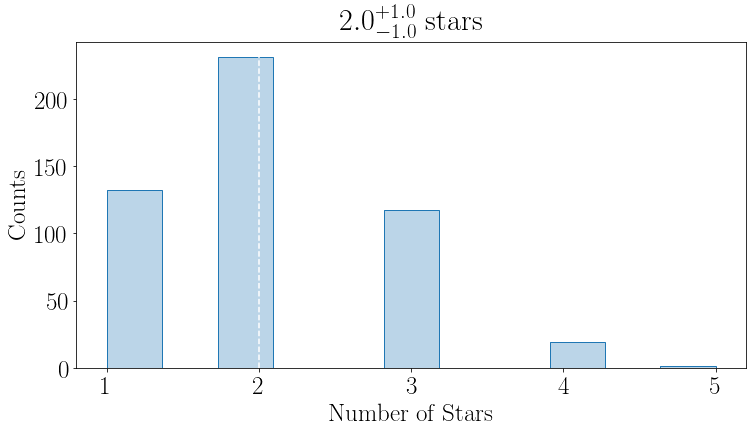

In [360]:
num_stars = count_star_wantexp()

# Plot exposure time hist
q_l, q_50, q_h, q_m, q_p = spectroscopy.nsig_intervals(num_stars)
result = "$%.1f^{+%.1f}_{-%.1f}$ stars" %(q_50, q_p, q_m)

fig, ax = plt.subplots(figsize = (12,6))
ax.set_xlabel("Number of Stars")
ax.set_ylabel("Counts")
ax.set_title(result)
ax.hist(num_stars, bins = Ndraw*2+1, alpha = .3, color = "C0");
ax.hist(num_stars, bins = Ndraw*2+1, alpha = 1.0, histtype="step", color = "C0");
ax.axvline(q_50, color = "w", ls = "dashed")

In [366]:
Xdraw = 500
eta_interesting = np.linspace(0.01, 0.99, 100)
ns_eta = np.zeros((len(eta_interesting), Xdraw))

for i, e_i in enumerate(eta_interesting):

    Nd = int(np.floor(e_i * NBIAS))
    
    ns_eta[i,:] = count_star_wantexp(Ndraw = Nd, Xdraw = Xdraw)

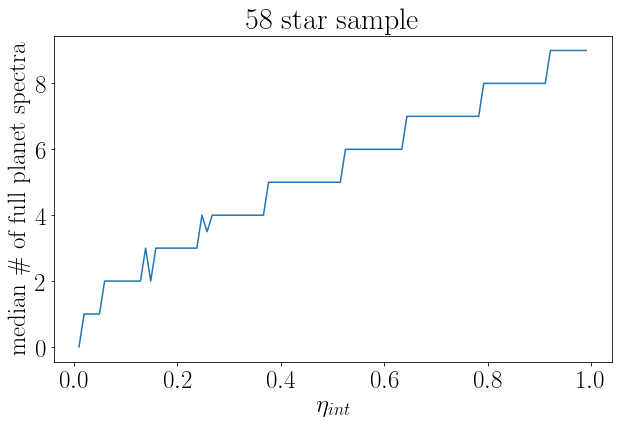

In [364]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_xlabel("$\eta_{int}$")
ax.set_ylabel("median \# of full planet spectra")
ax.set_title("%i star sample" %NBIAS)
ax.plot(eta_interesting, np.median(ns_eta, axis = 1))

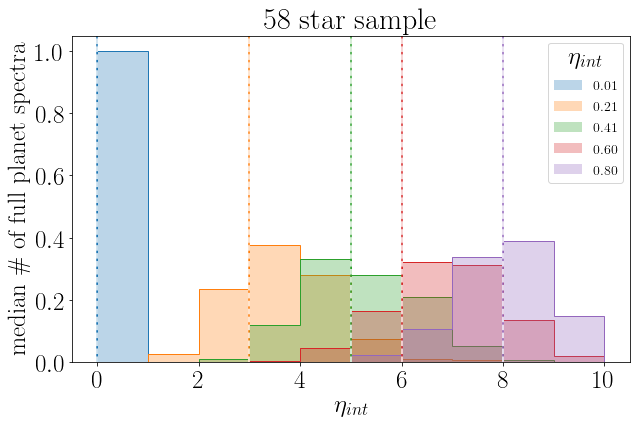

In [407]:
fig, ax = plt.subplots(figsize = (10,6))
ax.set_xlabel("$\eta_{int}$")
ax.set_ylabel("median \# of full planet spectra")
ax.set_title("%i star sample" %NBIAS)

xrange = (0, 10)

ic = 0
for i in range(0,ns_eta.shape[0])[::20]:
    c = "C%i" %ic
    ax.hist(ns_eta[i,:], bins = 2*Ndraw, alpha = .3, color = c, label = "%0.2f" %eta_interesting[i], normed=True, range = xrange);
    ax.hist(ns_eta[i,:], bins = 2*Ndraw, alpha = 1.0, histtype="step", color = c, normed=True, range = xrange);
    ax.axvline(np.median(ns_eta[i,:]), color = c)
    ax.axvline(np.median(ns_eta[i,:]), color = "w", ls = "dashed")
    ic += 1
    
ax.legend(title = "$\eta_{int}$", fontsize = 14, ncol = 1)